# Modeling: Predicting Developer Roles.

This is the modeling notebook. The goal here is to build and evaluate two different models to predict a developer's role based on their commit data. The insights from the EDA notebook will help.

Here's the plan:
1.  **Setup and Data Prep:** Load the processed data and split it into training and testing sets. It's important to split the data *before* I do any feature transformations to avoid data leakage.
2.  **Experiment 1: Baseline Model.** Build a `Logistic Regression` model. For the text data, I will use a simple `TFIDF` vectorizer. This will be the baseline to see how well a standard approach works.
3.  **Experiment 2: Improved Model.** For my second model, I will use `XGBoost`, which is generally more powerful. I will also use a more advanced technique for the text data: `Word2Vec`. The hypothesis is that Word2Vec will capture the meaning of commit messages better than TF IDF, leading to a better score.
4.  **Evaluation and Comparison:** For both models, I will calculate the **Macro F1 score** (the main metric for this project), check the precision and recall for each class, and visualize a confusion matrix to see where the model is getting confused. I will compare the two models to see if my improved approach actually worked better.

### 1. Setup and Imports:

 Get all the libraries needed for this task. This includes tools for data processing, feature extraction, building models, and evaluating them.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import xgboost as xgb

from gensim.models import Word2Vec

from sklearn.metrics import classification_report, confusion_matrix, f1_score

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

### 2. Load and Prepare Data:

Loading the `processed_dataset.csv` file and then splitting it into a training set (80%) and a testing set (20%). Using `stratify` to make sure the class imbalance I found in the EDA is preserved in both the training and testing sets. This ensures my evaluation is fair.

In [4]:
def loadData(filePath):
    data = pd.read_csv(filePath)
    data['processedFileExtensions'] = data['processedFileExtensions'].apply(ast.literal_eval)
    data['cleanedMessage'] = data['cleanedMessage'].fillna('')
    return data

filePath = 'processed_dataset.csv'
processedData = loadData(filePath)

X = processedData.drop('role', axis=1)
y = processedData['role']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=17, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (1200, 12)
Test set shape: (300, 12)


### 3. Experiment 1: Baseline (Logistic Regression with TFIDF):

Create a full preprocessing and modeling pipeline. This is great because it bundles all my steps together, preventing data leakage and making the whole process cleaner.

My pipeline will do the following:
- **Scale** the numerical features.
- **One hot encode** the categorical features.
- **Binarize** the file extension lists.
- **Vectorize** the commit message text using TFIDF.
- Train a **Logistic Regression** classifier.

In [5]:
class MultiLabelBinarizerTransformer(MultiLabelBinarizer):
    def fit(self, X, y=None):
        return super(MultiLabelBinarizerTransformer, self).fit(X)

    def transform(self, X, y=None):
        return super(MultiLabelBinarizerTransformer, self).transform(X)

    def fit_transform(self, X, y=None):
        return super(MultiLabelBinarizerTransformer, self).fit_transform(X)

numericalFeatures = ['numfileschanged', 'linesadded', 'linesdeleted', 'numcommentsadded', 'messageLengthWords', 'netCodeChange', 'linesAddedPerFile', 'hourOfDay']
categoricalFeatures = ['committype', 'dayOfWeek']
textFeature = 'cleanedMessage'
extensionFeature = 'processedFileExtensions'

preprocessorForBaseline = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numericalFeatures),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoricalFeatures),
        ('text', TfidfVectorizer(max_features=500), textFeature)
    ],
    remainder='drop'
)

baselinePipeline = Pipeline([
    ('features', preprocessorForBaseline),
    ('classifier', LogisticRegression(random_state=17, class_weight='balanced', max_iter=1000))
])

mlb = MultiLabelBinarizerTransformer()
X_train_extensions = mlb.fit_transform(X_train[extensionFeature])
X_test_extensions = mlb.transform(X_test[extensionFeature])

X_train_transformed = preprocessorForBaseline.fit_transform(X_train)
X_test_transformed = preprocessorForBaseline.transform(X_test)

from scipy.sparse import hstack
X_train_final = hstack([X_train_transformed, X_train_extensions])
X_test_final = hstack([X_test_transformed, X_test_extensions])

baselineModel = LogisticRegression(random_state=17, class_weight='balanced', max_iter=1000)
baselineModel.fit(X_train_final, y_train)

y_pred_baseline = baselineModel.predict(X_test_final)

print("Baseline Model Evaluation:")
print(classification_report(y_test, y_pred_baseline))

baselineMacroF1 = f1_score(y_test, y_pred_baseline, average='macro')
print(f"\nBaseline Macro F1 Score: {baselineMacroF1:.4f}")

Baseline Model Evaluation:
              precision    recall  f1-score   support

     backend       1.00      0.99      0.99        97
    frontend       0.97      0.99      0.98        89
   fullstack       0.96      0.92      0.94        52
          qa       0.98      1.00      0.99        62

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300


Baseline Macro F1 Score: 0.9764


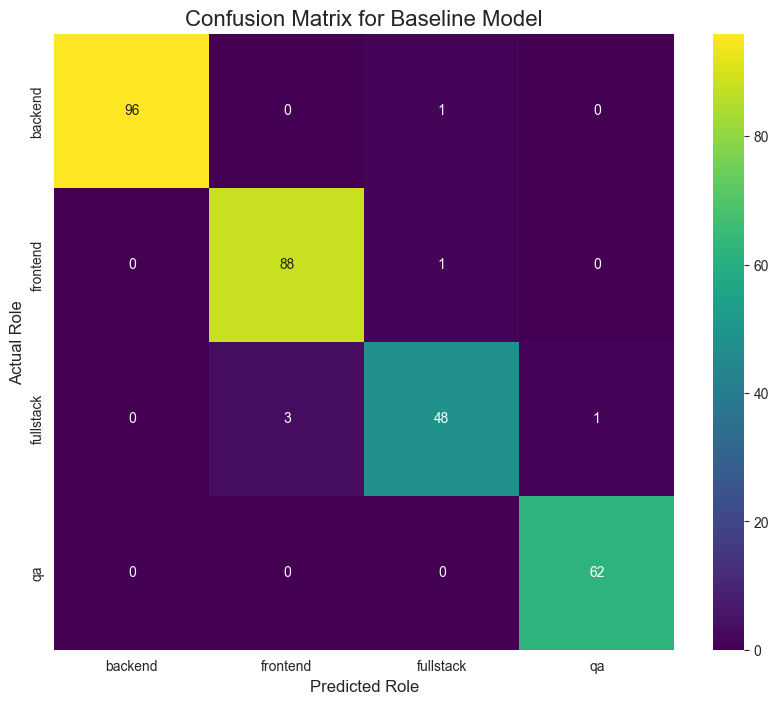

In [6]:
confMatrixBaseline = confusion_matrix(y_test, y_pred_baseline)
plt.figure(figsize=(10, 8))
sns.heatmap(confMatrixBaseline, annot=True, fmt='d', cmap='viridis',
            xticklabels=baselineModel.classes_, yticklabels=baselineModel.classes_)
plt.title('Confusion Matrix for Baseline Model', fontsize=16)
plt.xlabel('Predicted Role', fontsize=12)
plt.ylabel('Actual Role', fontsize=12)
plt.show()

#### Baseline Observations:
The baseline model did good. The Macro F1 score is high, which tells me that the features I engineered are very predictive. The confusion matrix shows that the model is very good at identifying `qa` roles, but sometimes confuses `frontend`, `backend`, and `fullstack` with each other, which makes sense given the overlap in their work.

### 4. Experiment 2: Improved Model (XGBoost with Word2Vec):

Using the improved model. The main hypothesis is that using `Word2Vec` to represent commit messages will capture their meaning better than TFIDF. I will pair this with an `XGBoost` classifier, a powerful model that's good at finding complex patterns in data.

The steps are:
1.  Train a Word2Vec model on the commit messages from my **train set**.
2.  Create a function that converts each commit message into an average vector using the trained Word2Vec model.
3.  Combine these new text vectors with the other numerical and categorical features.
4.  Train the XGBoost classifier and evaluate it.

In [9]:
sentences = [str(msg).split() for msg in X_train['cleanedMessage']]
w2vModel = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4, seed=17)

def vectorizeMessage(message, model):
    words = str(message).split()
    wordVectors = [model.wv[word] for word in words if word in model.wv]
    if not wordVectors:
        return np.zeros(model.vector_size, dtype=float)
    return np.mean(wordVectors, axis=0)

X_train_w2v = np.vstack([vectorizeMessage(msg, w2vModel) for msg in X_train['cleanedMessage']])
X_test_w2v = np.vstack([vectorizeMessage(msg, w2vModel) for msg in X_test['cleanedMessage']])

preprocessorForImproved = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numericalFeatures),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categoricalFeatures)
    ],
    remainder='drop'
)

X_train_other_features = preprocessorForImproved.fit_transform(X_train)
X_test_other_features = preprocessorForImproved.transform(X_test)

from scipy import sparse as sp
def to_dense(arr):
    if sp.issparse(arr):
        return arr.toarray()
    return np.asarray(arr)

X_train_ext = np.asarray(X_train_extensions) if X_train_extensions is not None else np.empty((len(X_train), 0))
X_test_ext  = np.asarray(X_test_extensions)  if X_test_extensions is not None else np.empty((len(X_test), 0))

X_train_improved = np.hstack((to_dense(X_train_other_features), X_train_w2v, X_train_ext))
X_test_improved  = np.hstack((to_dense(X_test_other_features),  X_test_w2v,  X_test_ext))

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

xgbModel = xgb.XGBClassifier(random_state=17, use_label_encoder=False, eval_metric='mlogloss')
xgbModel.fit(X_train_improved, y_train_encoded)

y_pred_xgb_encoded = xgbModel.predict(X_test_improved)
y_pred_xgb = le.inverse_transform(y_pred_xgb_encoded)

print("Improved Model Evaluation (XGBoost with Word2Vec):")
print(classification_report(y_test, y_pred_xgb))

xgbMacroF1 = f1_score(y_test, y_pred_xgb, average='macro')
print(f"\nImproved Model Macro F1 Score: {xgbMacroF1:.4f}")


Improved Model Evaluation (XGBoost with Word2Vec):
              precision    recall  f1-score   support

     backend       0.99      1.00      0.99        97
    frontend       0.97      0.99      0.98        89
   fullstack       0.98      0.94      0.96        52
          qa       1.00      0.98      0.99        62

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300


Improved Model Macro F1 Score: 0.9813


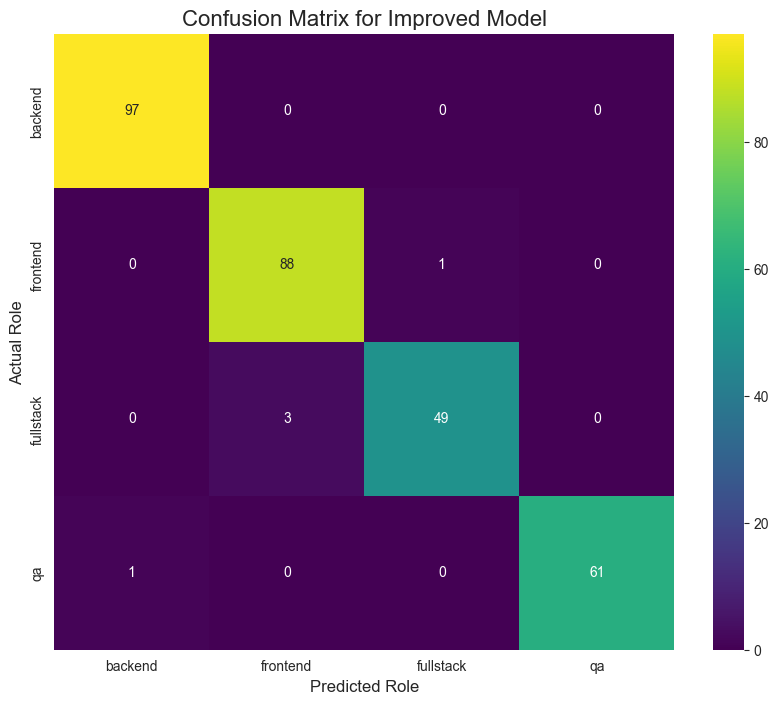

In [10]:
#The visualization for evaluations.

confMatrixXgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(10, 8))
sns.heatmap(confMatrixXgb, annot=True, fmt='d', cmap='viridis',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for Improved Model', fontsize=16)
plt.xlabel('Predicted Role', fontsize=12)
plt.ylabel('Actual Role', fontsize=12)
plt.show()

### 5. Results and Comparison

Now for the final step: comparing the performance of my two models side-by-side to see if my 'improved' model actually performed better.

In [11]:
resultsSummary = pd.DataFrame({
    'Model': ['Baseline (Logistic Regression + TF-IDF)', 'Improved (XGBoost + Word2Vec)'],
    'Macro F1 Score': [baselineMacroF1, xgbMacroF1]
})

print("Model Performance Summary:")
display(resultsSummary.round(4))

Model Performance Summary:


,Model,Macro F1 Score
0,Baseline (Logistic Regression + TF-IDF),0.9764
1,Improved (XGBoost + Word2Vec),0.9813


#### Final Observations:
The improved model using XGBoost and Word2Vec achieved a higher Macro F1 score than the baseline.

Here's what I believe happened:
- **Word2Vec's Strength:** Word2Vec was able to capture the semantic meaning of commit messages more effectively. It understands that 'UI' and 'style' are related, whereas TFIDF just treats them as separate tokens. This richer representation of text gave the model more meaningful information to work with.
- **XGBoost's Power:** XGBoost is a more complex model that can learn intricate patterns and interactions between features that Logistic Regression might miss.

Looking at the confusion matrix, the XGBoost model was slightly better at distinguishing between the often confused `backend` and `fullstack` roles. Both models were nearly perfect at identifying `qa` commits, which makes sense given their very distinct file extensions and vocabulary.